# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

# Custom Functions

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## Part 1

In [6]:
df = pd.read_csv('Data/zillow_home_values-zipcode.csv')
pd.set_option('display.max_columns', 50)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,...,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,107274.0,107076.0,107081.0,107112.0,107325.0,107480.0,107709.0,108092.0,108328.0,108782.0,109187.0,109242.0,109045.0,108514.0,108330.0,...,204564.0,206902.0,209154.0,212069.0,213553.0,215782.0,218494.0,223994.0,229959.0,236318.0,241418.0,246015.0,249379.0,253321.0,257274.0,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,222885.0,223602.0,224818.0,224384.0,224051.0,222942.0,223281.0,222886.0,223553.0,224715.0,226127.0,226742.0,226052.0,225191.0,224344.0,...,346146.0,350598.0,354599.0,359133.0,364502.0,370992.0,377896.0,386576.0,397227.0,408018.0,417061.0,424951.0,431973.0,437659.0,443701.0,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,90009.0,90042.0,90007.0,90027.0,89987.0,89972.0,89926.0,89397.0,88767.0,87904.0,87765.0,87719.0,87845.0,87409.0,87119.0,...,144471.0,146280.0,147989.0,149669.0,151475.0,153251.0,155948.0,158804.0,161832.0,164617.0,167493.0,169790.0,171741.0,173354.0,175355.0,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,190588.0,192155.0,194686.0,196246.0,198131.0,200596.0,202906.0,205407.0,208731.0,212367.0,215368.0,217915.0,220488.0,223666.0,226950.0,...,583072.0,582981.0,580157.0,578240.0,577104.0,577493.0,579678.0,579581.0,579996.0,579154.0,580023.0,578203.0,576272.0,572245.0,570414.0,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,277855.0,279802.0,282271.0,283679.0,284880.0,285975.0,288330.0,290339.0,293681.0,296592.0,299017.0,300344.0,302885.0,307212.0,311950.0,...,712619.0,716779.0,721142.0,722880.0,723884.0,724676.0,730056.0,733300.0,735223.0,734912.0,738325.0,741995.0,745001.0,745550.0,748738.0,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [7]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '31012000',
       ...
       '28022022', '31032022', '30042022', '31052022', '30062022', '31072022',
       '31082022', '30092022', '31102022', '30112022'],
      dtype='object', length=284)

In [8]:
melted = pd.melt(df,id_vars=['RegionID', 'SizeRank','RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'],value_name='Home Value',var_name='Date')
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,75810.0


In [9]:
melted['Date'] = pd.to_datetime(melted['Date'], format="%d%m%Y")
melted['Date']

0         2000-01-31
1         2000-01-31
2         2000-01-31
3         2000-01-31
4         2000-01-31
             ...    
7546545   2022-11-30
7546546   2022-11-30
7546547   2022-11-30
7546548   2022-11-30
7546549   2022-11-30
Name: Date, Length: 7546550, dtype: datetime64[ns]

In [10]:
melted = melted.set_index('Date')
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,110082.0


In [11]:
States = ['CA', 'WA', 'OR', 'AZ', 'NV']
df_tableau = melted[melted['State'].isin (States)]
df_tableau

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,143426.0
2000-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,144841.0
2000-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,163955.0
2000-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,163273.0
2000-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,110958.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,98502,30657,95950,zip,CA,CA,Grimes,NaN,Colusa County,313005.0
2022-11-30,95776,30657,89041,zip,NV,NV,Pahrump,"Pahrump, NV",Nye County,414072.0
2022-11-30,99923,30657,98623,zip,WA,WA,White Salmon,NaN,Klickitat County,729920.0


In [12]:
## Check Filtered Data by States
df_tableau['State'].unique()

array(['CA', 'WA', 'AZ', 'NV', 'OR'], dtype=object)

In [13]:
df_tableau = df_tableau.loc['2010' : '2020']
df_tableau

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2010-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,209250.0
2010-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,257372.0
2010-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,296430.0
2010-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,271829.0
2010-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,156704.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31,98502,30657,95950,zip,CA,CA,Grimes,NaN,Colusa County,220881.0
2020-12-31,95776,30657,89041,zip,NV,NV,Pahrump,"Pahrump, NV",Nye County,NaN
2020-12-31,99923,30657,98623,zip,WA,WA,White Salmon,NaN,Klickitat County,538209.0


In [14]:
## to Download this data in a “Data” folder
df_tableau.to_csv('Data/data-for-tableau.csv')

In [308]:
## Resample the home values, grouped by states, to a yearly frequency
ts_df = df_tableau.groupby('State').resample("A").mean()
ts_df

C:\Users\user\AppData\Local\Temp\ipykernel_14028\166363223.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_df = df_tableau.groupby('State').resample("A").mean()
C:\Users\user\AppData\Local\Temp\ipykernel_14028\166363223.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_df = df_tableau.groupby('State').resample("A").mean()
C:\Users\user\AppData\Local\Temp\ipykernel_14028\166363223.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be 

RegionID      SizeRank    RegionName     Home Value
State Date                                                                
AZ    2010-12-31  125430.669782   9836.641745  85550.336449  169930.889076
      2011-12-31  125430.669782   9836.641745  85550.336449  152272.467002
      2012-12-31  125430.669782   9836.641745  85550.336449  159902.057789
      2013-12-31  125430.669782   9836.641745  85550.336449  183657.225403
      2014-12-31  125430.669782   9836.641745  85550.336449  198551.492521
      2015-12-31  125430.669782   9836.641745  85550.336449  206834.173937
      2016-12-31  125430.669782   9836.641745  85550.336449  217452.799614
      2017-12-31  125430.669782   9836.641745  85550.336449  229066.028099
      2018-12-31  125430.669782   9836.641745  85550.336449  244689.172792
      2019-12-31  125430.669782   9836.641745  85550.336449  257396.582183
      2020-12-31  125430.669782   9836.641745  85550.336449  278841.942045
CA    2010-12-31   98747.743802   9324.490782  93598.652893  415491.808100
      2011-12-31   98747.743802   9324.490782  93598.652893  388468.031550
      2012-12-31   98747.743802   9324.490782  93598.652893  388593.634299
      2013-12-31   98747.743802   9324.490782  93598.652893  454509.845597
      2014-12-31   98747.743802   9324.490782  93598.652893  505808.423831
      2015-12-31   98747.743802   9324.490782  93598.652893  535297.119658
      2016-12-31   98747.743802   9324.490782  93598.652893  569319.272450
      2017-12-31   98747.743802   9324.490782  93598.652893  601938.428066
      2018-12-31   98747.743802   9324.490782  93598.652893  646936.553061
      2019-12-31   98747.743802   9324.490782  93598.652893  649531.475923
      2020-12-31   98747.743802   9324.490782  93598.652893  675124.170696
NV    2010-12-31  112977.664336  10727.580420  89265.237762  189285.319787
      2011-12-31  112977.664336  10727.580420  89265.237762  168931.537037
      2012-12-31  112977.664336  10727.580420  89265.237762  165003.293888
      2013-12-31  112977.664336  10727.580420  89265.237762  199847.532946
      2014-12-31  112977.664336  10727.580420  89265.237762  228975.139535
      2015-12-31  112977.664336  10727.580420  89265.237762  247372.119614
      2016-12-31  112977.664336  10727.580420  89265.237762  265123.976834
      2017-12-31  112977.664336  10727.580420  89265.237762  284543.217949
      2018-12-31  112977.664336  10727.580420  89265.237762  319753.462629
      2019-12-31  112977.664336  10727.580420  89265.237762  337914.425207
      2020-12-31  112977.664336  10727.580420  89265.237762  350564.885423
OR    2010-12-31  106076.819178  14728.101370  97394.490411  224035.019849
      2011-12-31  106076.819178  14728.101370  97394.490411  205273.042225
      2012-12-31  106076.819178  14728.101370  97394.490411  201899.022119
      2013-12-31  106076.819178  14728.101370  97394.490411  216964.502931
      2014-12-31  106076.819178  14728.101370  97394.490411  233022.531108
      2015-12-31  106076.819178  14728.101370  97394.490411  249633.916898
      2016-12-31  106076.819178  14728.101370  97394.490411  272424.454568
      2017-12-31  106076.819178  14728.101370  97394.490411  294524.759060
      2018-12-31  106076.819178  14728.101370  97394.490411  311491.056020
      2019-12-31  106076.819178  14728.101370  97394.490411  323800.937928
      2020-12-31  106076.819178  14728.101370  97394.490411  338782.970027
WA    2010-12-31   99857.935728  13383.391304  98603.703214  250932.487018
      2011-12-31   99857.935728  13383.391304  98603.703214  230557.026098
      2012-12-31   99857.935728  13383.391304  98603.703214  225432.142832
      2013-12-31   99857.935728  13383.391304  98603.703214  240848.444598
      2014-12-31   99857.935728  13383.391304  98603.703214  256869.916239
      2015-12-31   99857.935728  13383.391304  98603.703214  275704.942220
      2016-12-31   99857.935728  13383.391304  98603.703214  302116.532078
      2017-12-31   99857.935728  13383.391304  9

In [287]:
ts_df = ts_df[['Home Value']].round(3)
ts_df.head()

Home Value
State Date                  
AZ    2010-12-31  169930.889
      2011-12-31  152272.467
      2012-12-31  159902.058
      2013-12-31  183657.225
      2014-12-31  198551.493

In [56]:
unstacked = ts_df.unstack(level=0)
unstacked

Home Value                                                
State               AZ          CA          NV          OR          WA
Date                                                                  
2010-12-31  169930.889  415491.808  189285.320  224035.020  250932.487
2011-12-31  152272.467  388468.032  168931.537  205273.042  230557.026
2012-12-31  159902.058  388593.634  165003.294  201899.022  225432.143
2013-12-31  183657.225  454509.846  199847.533  216964.503  240848.445
2014-12-31  198551.493  505808.424  228975.140  233022.531  256869.916
2015-12-31  206834.174  535297.120  247372.120  249633.917  275704.942
2016-12-31  217452.800  569319.272  265123.977  272424.455  302116.532
2017-12-31  229066.028  601938.428  284543.218  294524.759  334494.268
2018-12-31  244689.173  646936.553  319753.463  311491.056  367370.463
2019-12-31  257396.582  649531.476  337914.425  323800.938  381711.639
2020-12-31  278841.942  675124.171  350564.885  338782.970  408430.210

In [53]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in thousands"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"

# Create the formatters
fmt_thous = mticks.FuncFormatter(thousands)

Text(0, 0.5, 'Avg Value')

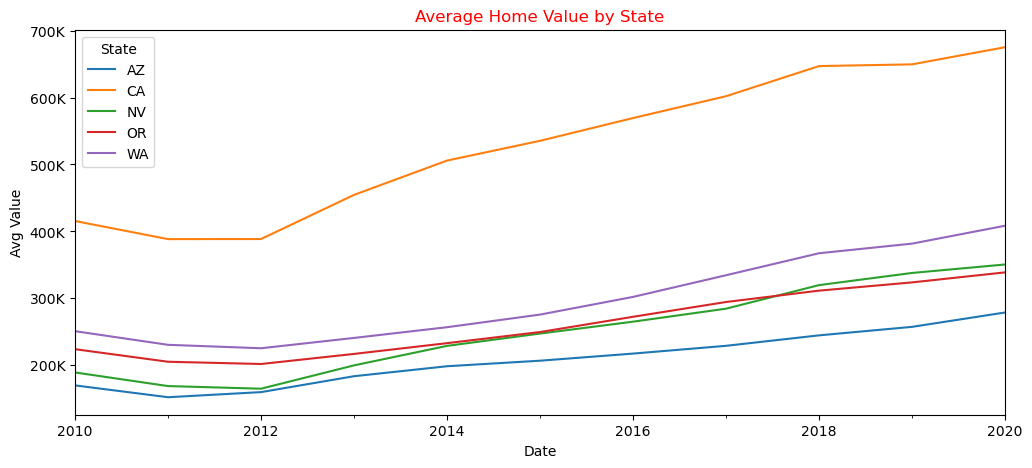

In [54]:
ax = unstacked['Home Value'].plot(figsize = (12,5))
ax.yaxis.set_major_formatter(fmt_thous)
plt.title('Average Home Value by State', color = 'red')
plt.ylabel('Avg Value')

## Part 2

In [181]:
## Import Data again
df_2 = pd.read_csv('Data/zillow_home_values-zipcode.csv')
pd.set_option('display.max_columns', 50)
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,...,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,107274.0,107076.0,107081.0,107112.0,107325.0,107480.0,107709.0,108092.0,108328.0,108782.0,109187.0,109242.0,109045.0,108514.0,108330.0,...,204564.0,206902.0,209154.0,212069.0,213553.0,215782.0,218494.0,223994.0,229959.0,236318.0,241418.0,246015.0,249379.0,253321.0,257274.0,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,222885.0,223602.0,224818.0,224384.0,224051.0,222942.0,223281.0,222886.0,223553.0,224715.0,226127.0,226742.0,226052.0,225191.0,224344.0,...,346146.0,350598.0,354599.0,359133.0,364502.0,370992.0,377896.0,386576.0,397227.0,408018.0,417061.0,424951.0,431973.0,437659.0,443701.0,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,90009.0,90042.0,90007.0,90027.0,89987.0,89972.0,89926.0,89397.0,88767.0,87904.0,87765.0,87719.0,87845.0,87409.0,87119.0,...,144471.0,146280.0,147989.0,149669.0,151475.0,153251.0,155948.0,158804.0,161832.0,164617.0,167493.0,169790.0,171741.0,173354.0,175355.0,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,190588.0,192155.0,194686.0,196246.0,198131.0,200596.0,202906.0,205407.0,208731.0,212367.0,215368.0,217915.0,220488.0,223666.0,226950.0,...,583072.0,582981.0,580157.0,578240.0,577104.0,577493.0,579678.0,579581.0,579996.0,579154.0,580023.0,578203.0,576272.0,572245.0,570414.0,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,277855.0,279802.0,282271.0,283679.0,284880.0,285975.0,288330.0,290339.0,293681.0,296592.0,299017.0,300344.0,302885.0,307212.0,311950.0,...,712619.0,716779.0,721142.0,722880.0,723884.0,724676.0,730056.0,733300.0,735223.0,734912.0,738325.0,741995.0,745001.0,745550.0,748738.0,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [182]:
melted_2 = pd.melt(df_2,id_vars=['RegionID', 'SizeRank','RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'],value_name='Home Value',var_name='Date')
melted_2

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,75810.0


In [183]:
melted_2['Date'] = pd.to_datetime(melted_2['Date'], format="%d%m%Y")
ts = melted_2.set_index('Date')
ts

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,110082.0


In [184]:
ts_resampled = ts.groupby('State').resample('M').mean()
ts_resampled

C:\Users\user\AppData\Local\Temp\ipykernel_14028\1076854353.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_resampled = ts.groupby('State').resample('M').mean()
C:\Users\user\AppData\Local\Temp\ipykernel_14028\1076854353.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_resampled = ts.groupby('State').resample('M').mean()
C:\Users\user\AppData\Local\Temp\ipykernel_14028\1076854353.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be

RegionID      SizeRank    RegionName     Home Value
State Date                                                                
AK    2000-01-31  107639.159091  14009.909091  99622.772727  162013.153846
      2000-02-29  107639.159091  14009.909091  99622.772727  162853.692308
      2000-03-31  107639.159091  14009.909091  99622.772727  163250.384615
      2000-04-30  107639.159091  14009.909091  99622.772727  163874.923077
      2000-05-31  107639.159091  14009.909091  99622.772727  164129.384615
...                         ...           ...           ...            ...
WY    2022-07-31   93946.763636  20476.618182  82554.990909  382379.175926
      2022-08-31   93946.763636  20476.618182  82554.990909  384423.111111
      2022-09-30   93946.763636  20476.618182  82554.990909  386021.388889
      2022-10-31   93946.763636  20476.618182  82554.990909  388643.870370
      2022-11-30   93946.763636  20476.618182  82554.990909  387056.427273

[14025 rows x 4 columns]

In [186]:
ts_resampled.index

MultiIndex([('AK', '2000-01-31'),
            ('AK', '2000-02-29'),
            ('AK', '2000-03-31'),
            ('AK', '2000-04-30'),
            ('AK', '2000-05-31'),
            ('AK', '2000-06-30'),
            ('AK', '2000-07-31'),
            ('AK', '2000-08-31'),
            ('AK', '2000-09-30'),
            ('AK', '2000-10-31'),
            ...
            ('WY', '2022-02-28'),
            ('WY', '2022-03-31'),
            ('WY', '2022-04-30'),
            ('WY', '2022-05-31'),
            ('WY', '2022-06-30'),
            ('WY', '2022-07-31'),
            ('WY', '2022-08-31'),
            ('WY', '2022-09-30'),
            ('WY', '2022-10-31'),
            ('WY', '2022-11-30')],
           names=['State', 'Date'], length=14025)

In [190]:
ts_resampled = ts_resampled[['Home Value']].round(3)
ts_resampled

Home Value
State Date                  
AK    2000-01-31  162013.154
      2000-02-29  162853.692
      2000-03-31  163250.385
      2000-04-30  163874.923
      2000-05-31  164129.385
...                      ...
WY    2022-07-31  382379.176
      2022-08-31  384423.111
      2022-09-30  386021.389
      2022-10-31  388643.870
      2022-11-30  387056.427

[14025 rows x 1 columns]

In [192]:
state = 'OR'
ts_or = ts_resampled.loc[state]
ts_or

,Home Value
Date,
2000-01-31,162508.613
2000-02-29,162913.172
2000-03-31,163011.126
2000-04-30,163541.908
2000-05-31,164176.421
...,...
2022-07-31,461233.036
2022-08-31,461219.499
2022-09-30,461302.785


In [193]:
ts_filtred = ts_or.loc['2000':'2018']
ts_filtred

,Home Value
Date,
2000-01-31,162508.613
2000-02-29,162913.172
2000-03-31,163011.126
2000-04-30,163541.908
2000-05-31,164176.421
...,...
2018-08-31,313844.697
2018-09-30,315055.306
2018-10-31,316216.785


In [194]:
## Check Missing Values
ts_filtred.isnull().sum()

Home Value    0
dtype: int64

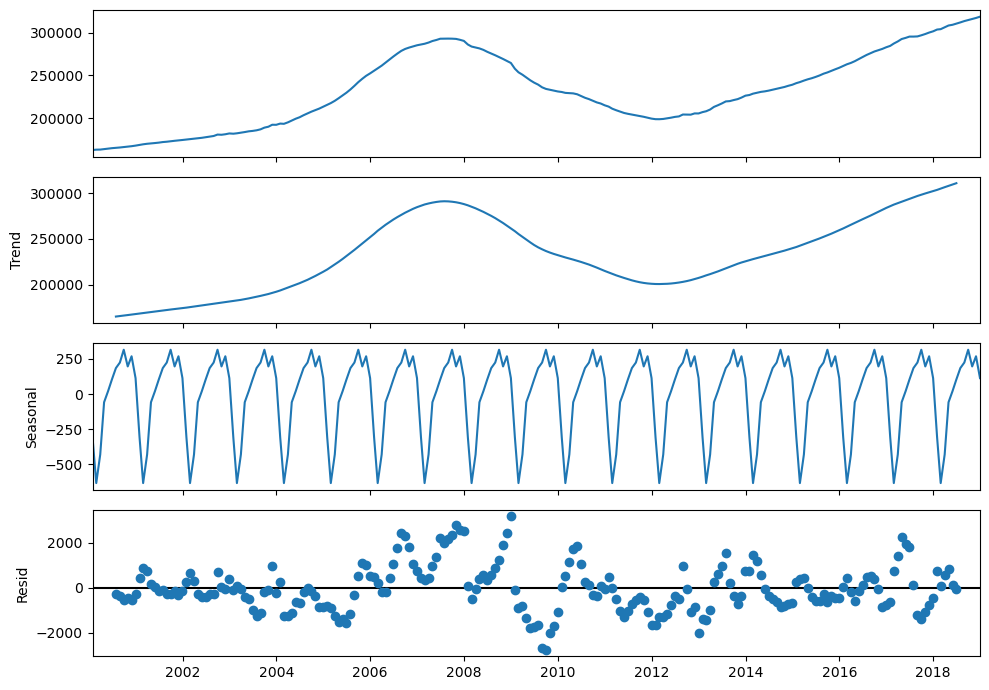

In [195]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_filtred)
fig = decomp.plot()
fig.set_size_inches(10,7)
fig.tight_layout()

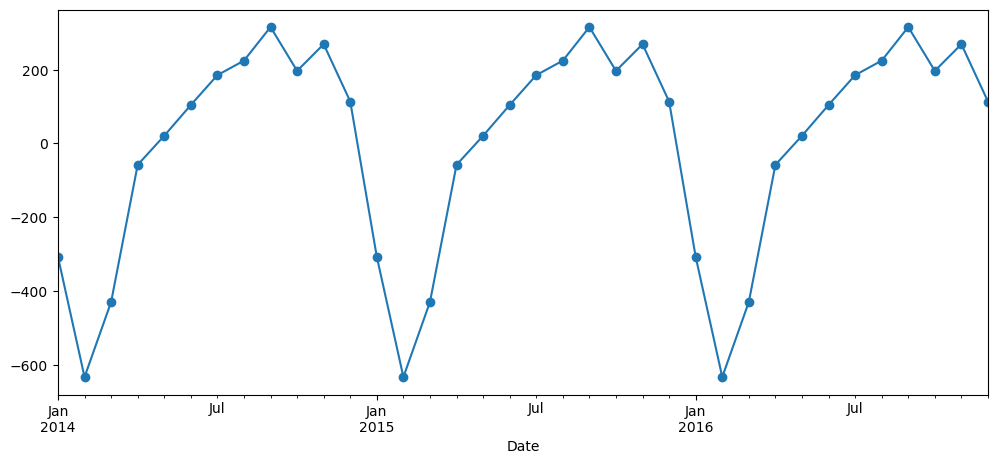

In [196]:
seasonal = decomp.seasonal
ax = seasonal.loc['2014': '2016'].plot(marker = 'o', figsize = (12,5))

*  **Based on the graph, we can observe the presence of seasonality.**
*  **There are 12 points between peaks,indicating a seasonal period of 12 months.**

In [198]:
# check for nonseasonal differencing
ndiffs(ts_filtred)

2

<Axes: xlabel='Date'>

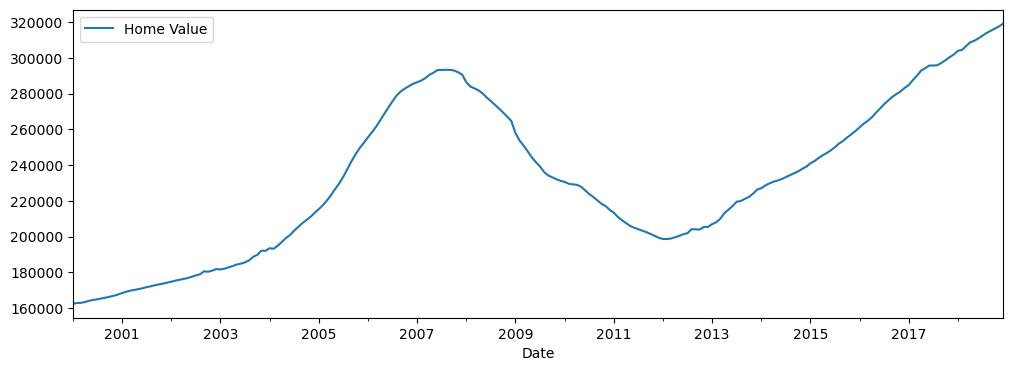

In [200]:
# to approve d = 2, first plot ts_filtred
ts_filtred.plot(figsize=(12,4))

In [204]:
# Test for stationarity
get_adfuller_results(ts_filtred)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.786015,3,224,0.387427,0.05,False


In [205]:
# Differenced ts_filtred
ts_filtred_diff = ts_filtred.diff().dropna()
ts_filtred_diff

,Home Value
Date,
2000-02-29,404.559
2000-03-31,97.954
2000-04-30,530.782
2000-05-31,634.513
2000-06-30,487.887
...,...
2018-08-31,1554.415
2018-09-30,1210.609
2018-10-31,1161.479


In [206]:
# Test for stationarity ts_filtred_diff
get_adfuller_results(ts_filtred_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.072161,2,224,0.255855,0.05,False


<Axes: xlabel='Date'>

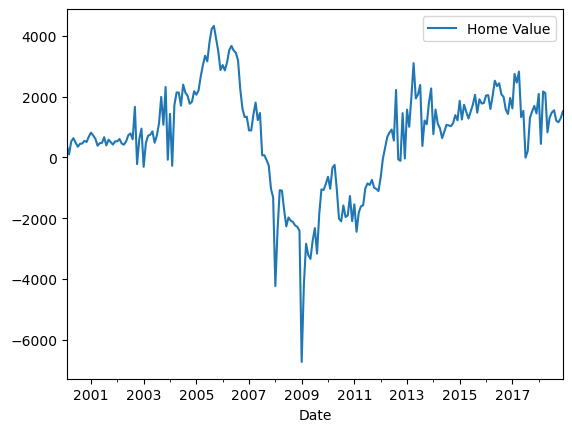

In [210]:
# plot ts_filtred_diff
ts_filtred_diff.plot()

In [207]:
# Differenced ts_filtred_diff
ts_filtred_diff_2 = ts_filtred.diff().diff().dropna()
ts_filtred_diff_2

,Home Value
Date,
2000-03-31,-306.605
2000-04-30,432.828
2000-05-31,103.731
2000-06-30,-146.626
2000-07-31,-134.791
...,...
2018-08-31,72.659
2018-09-30,-343.806
2018-10-31,-49.130


In [208]:
# Test for stationarity ts_filtred_diff_2
get_adfuller_results(ts_filtred_diff_2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-13.956008,1,224,0.0,0.05,True


<Axes: xlabel='Date'>

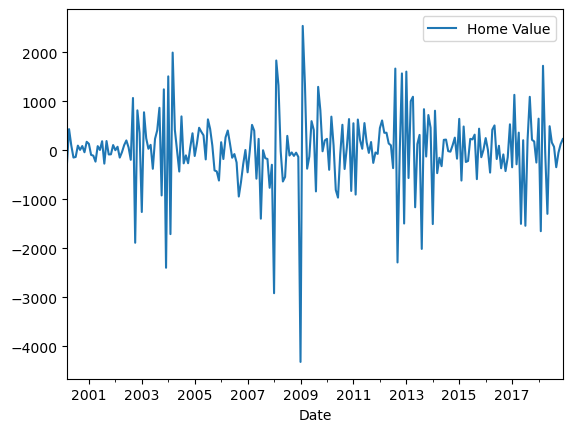

In [209]:
# plot ts_filtred_diff_2
ts_filtred_diff_2.plot()

==>  **Now, it's clear d = 2**

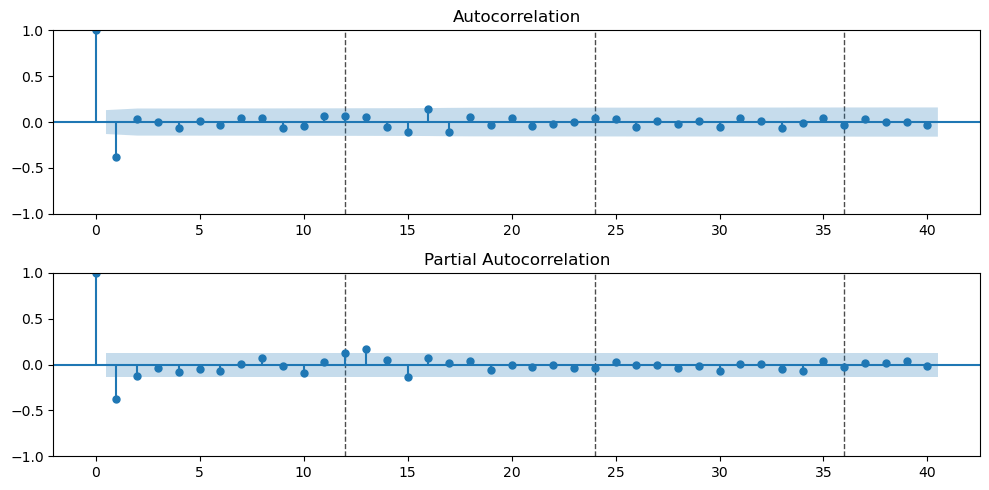

In [212]:
# Check differenced ts_filtred_diff_2 for autocorrelation (ACF) and Partial Autocorrelation (PACF)
plot_acf_pacf(ts_filtred_diff_2, annotate_seas=True, m = 12);

*  The PACF plot above shows a very abrupt drop after lag 1. This indicates that we only need one coefficient in our AR model. In this case, p = 1.
*  Looking at the ACF, we see the dropoff occurs after the 1st lag, so we will estimate an q = 1.

In [216]:
### Now find P and Q (D = 0 because d + D = 2 when d = 2, D = 0)
## Chek D= 0
# Determine D
D = nsdiffs(ts_filtred, m =12)
print(f'D = {D}')

D = 0


*  The seasonal lags in the PACF show a gradual decrease, and the same for seasonal lags in the ACF, so we will start with a P = 0, and Q = 0

### **We now have a starting point for our model: (1,2,1)(0,0,0)[12]**

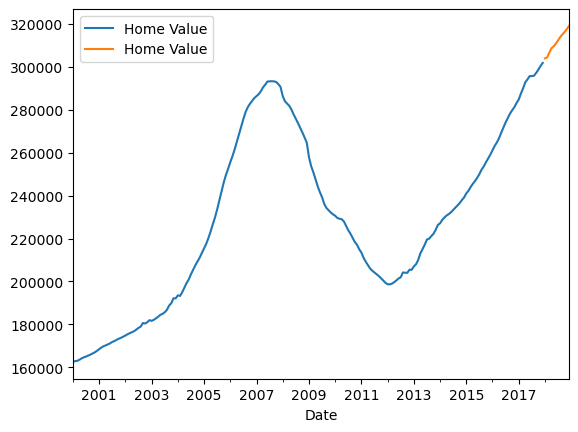

In [235]:
train, test = train_test_split(ts_filtred, test_size= 12)
ax = train.plot(label = 'Train')
ax = test.plot(ax=ax, label = 'Test')
ax.legend();

In [236]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Home Value   No. Observations:                  216
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1725.837
Date:                Sun, 23 Jun 2024   AIC                           3457.674
Time:                        00:47:28   BIC                           3467.772
Sample:                    01-31-2000   HQIC                          3461.755
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5758      1.083      0.532      0.595      -1.548       2.699
ma.L1         -0.5967      1.091     -0.547      0.585      -2.735       1.542
sigma2      5.151e+05    2.2e+04     23.396      0.000    4.72e+05    5.58e+05
===================================================================================
Ljung-Box (L1) (Q):                  26.30   Jarque-Bera (JB):               363.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -1.16
Prob(H) (two-sided):                  0.28   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

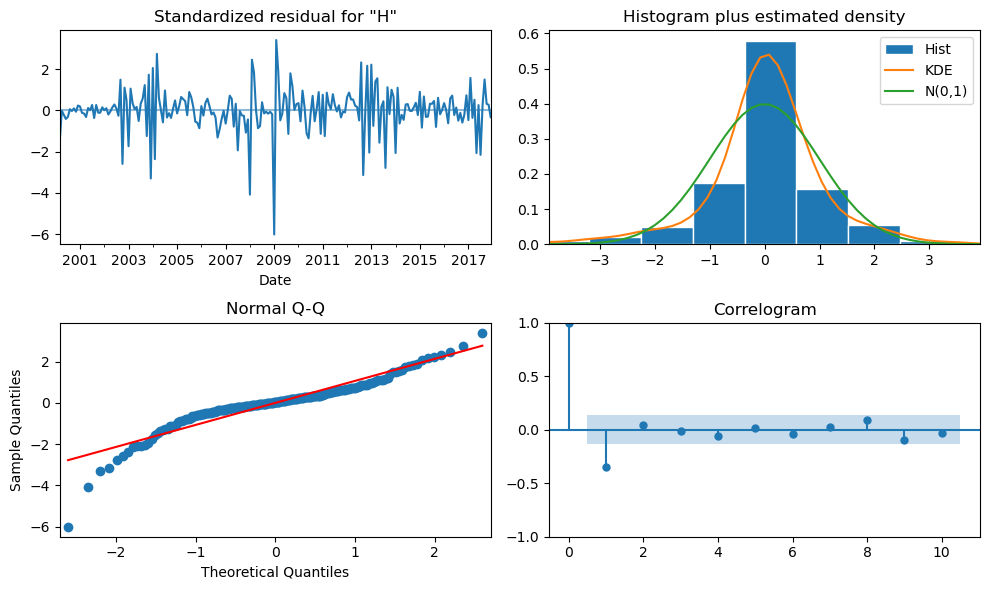

In [237]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 385.086
- MSE = 207,922.918
- RMSE = 455.986
- R^2 = 0.991
- MAPE = 0.12%


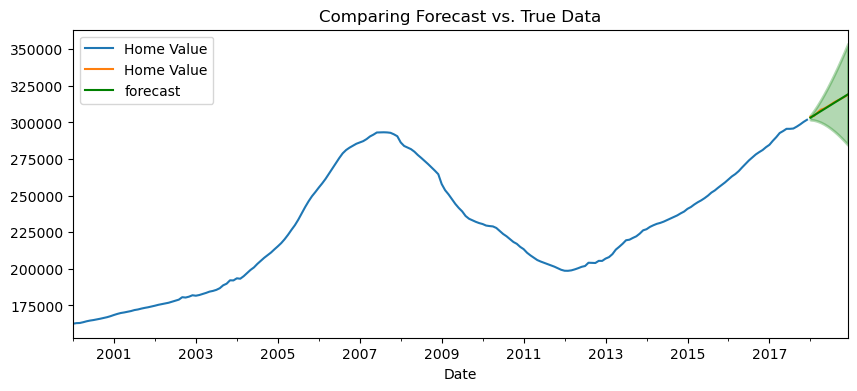

In [238]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [243]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    d=2,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=3465.010, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3453.299, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3458.298, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3458.183, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3455.380, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3455.126, Time=0.14 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3458.425, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3454.641, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3456.399, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3457.674, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=3455.285, Time=0.04 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.327 seconds


In [244]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1725.649
Date:                Sun, 23 Jun 2024   AIC                           3453.299
Time:                        00:50:42   BIC                           3456.665
Sample:                    01-31-2000   HQIC                          3454.659
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.871e+05   2.82e+04     20.794      0.000    5.32e+05    6.42e+05
===================================================================================
Ljung-Box (L1) (Q):                  28.80   Jarque-Bera (JB):               367.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -1.14
Prob(H) (two-sided):                  0.23   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

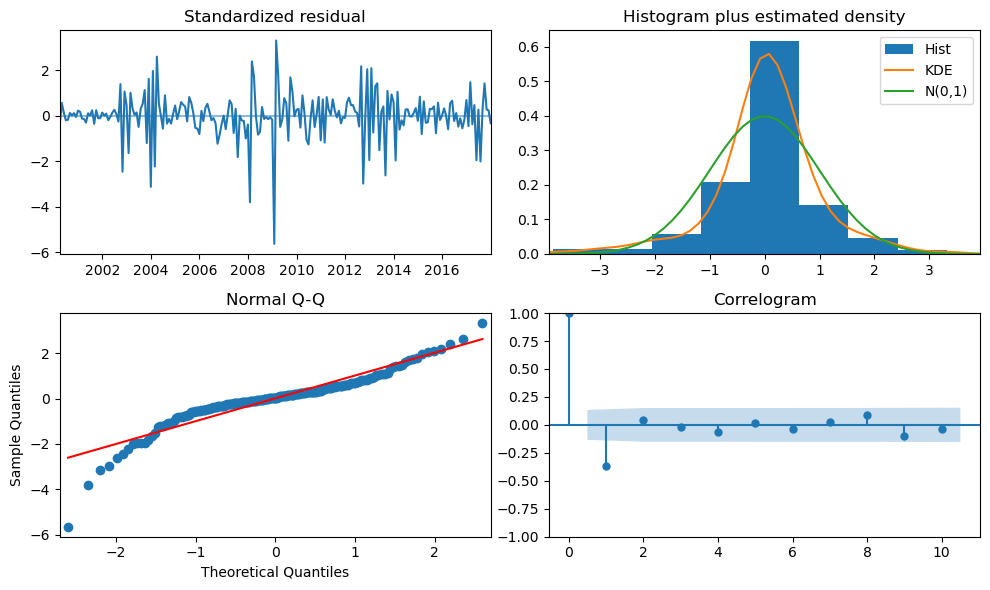

In [245]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 384.272
- MSE = 204,448.361
- RMSE = 452.160
- R^2 = 0.991
- MAPE = 0.12%


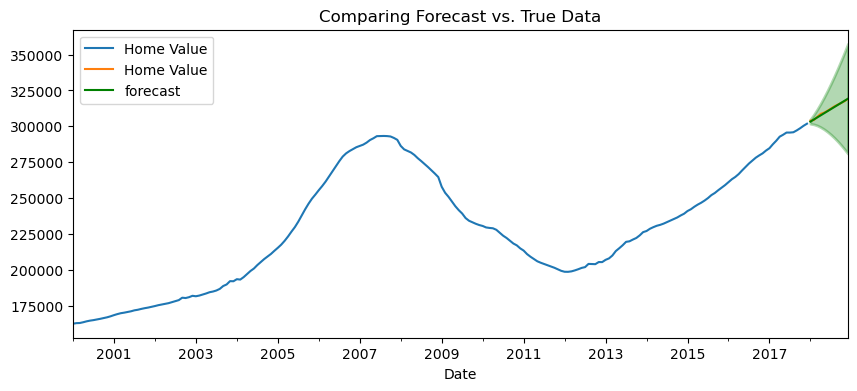

In [246]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

### **The manuel Sarima Model and the auto one seems to perform well with high R^2 and low MAE and MAPE.**

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

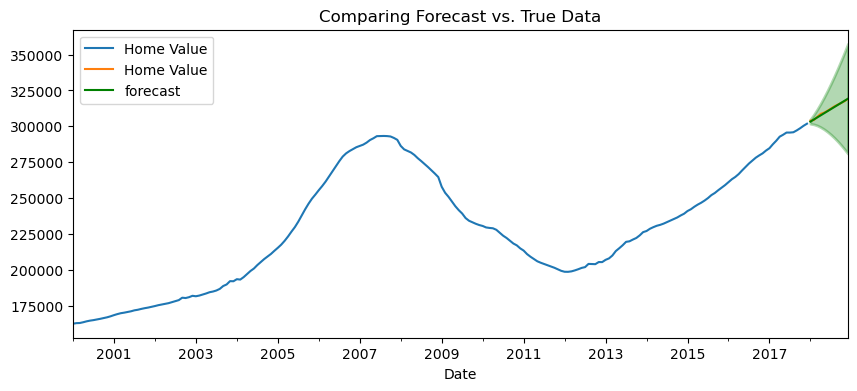

In [261]:
# Obtain future forecasts beyond test data
final_model = auto_model
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df)

In [247]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2018-01-31 00:00:00', freq='M'),
 Timestamp('2018-12-31 00:00:00', freq='M'))

In [251]:
starting_value = forecast_df['mean'].iloc[0]
starting_value.round(3)

303268.475

In [253]:
final_value = forecast_df['mean'].iloc[-1]
final_value.round(3)

319223.832

In [252]:
change = final_value - starting_value
change.round(3)

15955.357

In [255]:
perc_change = (change / starting_value) * 100
perc_change.round(3)

5.261

*  **The Home Value in Oregan is a percent increase of about 6%.**

## Part 3

### # Tableau Workbook

https://public.tableau.com/views/HomeValueInUSA/ChoroplethMapoftheMedianHomeValuebyZipCode?:language=fr-FR&publish=yes&:sid=&:display_count=n&:origin=viz_share_link